# Read output data from gam_model.ipynb and make the figures and tables

__Note on the environment required to run the notebook:__

An installation of Python 3.9 with recent versions of the libraries (numpy, scipy, matplotlib, pandas, xarray, statsmodels) should run this Notebook wihout modification.

In [478]:
from scipy.stats import norm, linregress
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import local_functions as loc

In [452]:
# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')


In [453]:
region = 'Netherlands' # Choose from 'Netherlands', 'Belgium', 'Vlissingen', 'Hoek van Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden'
bootsize = 10000 # Choose from 100, 1000, 10000

In [454]:
output_dir = f'./outputs/{region}/'

## Summary table of model performance

In [455]:
resm_df = pd.read_csv(f'{output_dir}{bootsize}/table_model_performance.csv')
resm_df.set_index('Statistical model', inplace=True)
resm_df['Model equation'] = ['$\eta_i=  \sum_j \alpha_{j} \phi_{ji}$', 
                             '$\eta_i = \sum_j \alpha_{j} \phi_{ji} + \beta_{1} \cos(2\pi i /18.613) + \beta_{2} \sin(2\pi i /18.613)$', 
                             '$\eta_i = \sum_j \alpha_{j} \phi_{ji} + \beta_{1} \cos(2\pi i /18.613) + \beta_{2} \sin(2\pi i /18.613)  +  \beta_{3} |u_i|u_i$', 
                             '$\eta_i = \sum_j \alpha_{j} \phi_{ji} + \beta_{1} \cos(2\pi i /18.613) + \beta_{2} \sin(2\pi i /18.613)  +  \beta_{4} \Delta p_i$']
resm_df = resm_df[['Model equation', 'Degrees of freedom', 'Deviance']]

In [456]:
resm_df

,Model equation,Degrees of freedom,Deviance
Statistical model,,,
Tr : Trend only,$\eta_i= \sum_j lpha_{j} \phi_{ji}$,4.7,1167.0
TrNc : Trend and nodal tide,$\eta_i = \sum_j lpha_{j} \phi_{ji} + eta_{1...,6.6,1033.0
"TrNcZw : Trend, nodal tide and wind (velocity)",$\eta_i = \sum_j lpha_{j} \phi_{ji} + eta_{1...,7.6,428.0
"TrNcPd : Trend, nodal tide and wind (pressure)",$\eta_i = \sum_j lpha_{j} \phi_{ji} + eta_{1...,7.6,652.0


Add column for equations

Export to latex table format to copy paste directly to the paper

In [457]:
print(resm_df.to_latex())

\begin{tabular}{llrr}
\toprule
{} &                                     Model equation &  Degrees of freedom &  Deviance \\
Statistical model                              &                                                    &                     &           \\
\midrule
Tr : Trend only                                &              \$\textbackslash eta\_i=  \textbackslash sum\_j lpha\_\{j\} \textbackslash phi\_\{ji\}\$ &                 4.7 &    1167.0 \\
TrNc : Trend and nodal tide                    &  \$\textbackslash eta\_i = \textbackslash sum\_j lpha\_\{j\} \textbackslash phi\_\{ji\} +eta\_\{1... &                 6.6 &    1033.0 \\
TrNcZw : Trend, nodal tide and wind (velocity) &  \$\textbackslash eta\_i = \textbackslash sum\_j lpha\_\{j\} \textbackslash phi\_\{ji\} +eta\_\{1... &                 7.6 &     428.0 \\
TrNcPd : Trend, nodal tide and wind (pressure) &  \$\textbackslash eta\_i = \textbackslash sum\_j lpha\_\{j\} \textbackslash phi\_\{ji\} +eta\_\{1... &             

/var/folders/sg/bjgd139d48v526p07tp867mh0000gn/T/ipykernel_13859/3890745105.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(resm_df.to_latex())


### Also compute some percentages for the paper

Deviance

In [458]:
resm_df.Deviance

Statistical model
Tr : Trend only                                   1167.0
TrNc : Trend and nodal tide                       1033.0
TrNcZw : Trend, nodal tide and wind (velocity)     428.0
TrNcPd : Trend, nodal tide and wind (pressure)     652.0
Name: Deviance, dtype: float64

In [459]:
round(100-100*resm_df.Deviance[1]/resm_df.Deviance[0],0)

11.0

In [460]:
round(100-100*resm_df.Deviance[2]/resm_df.Deviance[1],0)

59.0

In [461]:
round(100-100*resm_df.Deviance[3]/resm_df.Deviance[1],0)

37.0

## Read rates data

In [479]:
tg_df = pd.read_csv(f'{output_dir}data_tide_gauges.csv')

res_nr = pd.read_csv(f'{output_dir}results_NoRegressor.csv')
res_nt = pd.read_csv(f'{output_dir}results_NodalTide.csv')
res_na = pd.read_csv(f'{output_dir}results_NearestPointAverage.csv')
res_pd = pd.read_csv(f'{output_dir}results_PressureDifference.csv')

for df in [tg_df, res_nr, res_nt, res_na, res_pd]:
    df.set_index('time', inplace=True)

In [ ]:
rates_nr = pd.read_csv(f'{output_dir}{bootsize}/rates_NoRegressor.csv')
rates_nt = pd.read_csv(f'{output_dir}{bootsize}/rates_NodalTide.csv')
rates_na = pd.read_csv(f'{output_dir}{bootsize}/rates_NearestPointAverage.csv')
rates_pd = pd.read_csv(f'{output_dir}{bootsize}/rates_PressureDifference.csv')

rates_q_nr = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_NoRegressor.csv')
rates_q_nt = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_NodalTide.csv')
rates_q_na = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_NearestPointAverage.csv')
rates_q_pd = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_PressureDifference.csv')

for df in [rates_nr, rates_nt, rates_na, rates_pd,
           rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd,]:
    df.set_index('time', inplace=True)

In [ ]:
# Compute the standard errors in rates

ser_nr = rates_nr.std(axis=1)
ser_nt = rates_nt.std(axis=1)
ser_na = rates_na.std(axis=1)
ser_pd = rates_pd.std(axis=1)

In [ ]:
long_names = ['Trend only', 
              'Trend and nodal tide', 
              'Trend, nodal tide and wind (velocity)', 
              'Trend, nodal tide and wind (pressure)']

short_names = ['Tr', 'TrNc', 'TrNcZw', 'TrNcPd']

comb_names = [f'{short_names[i]} : {long_names[i]}' for i in range(4)]

## Compute some p-values

### Hypothesis that the rates are the same at different years

In [ ]:
t1 = 2019
all_t0 = [1900, 1960]

list_rates = [rates_nr, rates_nt, rates_na, rates_pd]
list_rates_q = [rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd]

col_names = [f'p-values [r({t1}) , r({y})]' for y in all_t0]

res_ar = np.zeros([4, 2])

for idt, t0 in enumerate(all_t0):
    for idd, (rates, rates_q) in enumerate(zip(list_rates, list_rates_q)):

        sigma = np.std(rates.loc[t1] - rates.loc[t0])

        # observed difference in rate
        drate = rates_q['0.5'].loc[t1] - rates_q['0.5'].loc[t0]

        # p-value is the probability that the estimated rate difference would exceed  
        # the value drate if the true rates were equal
        # (this looks like your formula!)
        res_ar[idd, idt] = round(1-norm.cdf(drate/sigma), 2)
    
res_df = pd.DataFrame(res_ar, 
                      index=short_names, 
                      columns=col_names)

res_df.index.name = 'Statistical model'

In [ ]:
res_df

### Hypothesis that the rates are the same at different periods

In [ ]:
t1 = 2000
all_t0 = [1900, 1920, 1940]

list_rates = [rates_nr, rates_nt, rates_na, rates_pd]
list_rates_q = [rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd]

col_names = [f'r_{{{t1}-{t1+19}}} vs r_{{{y}-{y+19}}}' for y in all_t0]

res_ar = np.zeros([4, 3])

for idt, t0 in enumerate(all_t0):
    for idd, (rates, rates_q) in enumerate(zip(list_rates, list_rates_q)):
        sigma = np.std(rates.loc[t1: t1+19].mean(axis=0) - 
                       rates.loc[t0: t0+19].mean(axis=0))

        # observed difference in rate
        drate = (rates_q['0.5'].loc[t1: t1+19].mean(axis=0) - 
                 rates_q['0.5'].loc[t0: t0+19].mean(axis=0))

        # p-value is the probability that the estimated rate difference would exceed  
        # the value drate if the true rates were equal
        res_ar[idd, idt] = round(1-norm.cdf(drate/sigma), 2)
    
res_df = pd.DataFrame(res_ar, 
                      index=short_names, 
                      columns=col_names)

res_df.index.name = 'Statistical model'

In [463]:
res_df

,r_{2000-2019} vs r_{1900-1919},r_{2000-2019} vs r_{1920-1939},r_{2000-2019} vs r_{1940-1959}
Statistical model,,,
Tr,0.25,0.76,0.61
TrNc,0.19,0.71,0.54
TrNcZw,0.06,0.63,0.40
TrNcPd,0.11,0.74,0.51


In [464]:
res_df_100 = res_df*100  # Show results in percentages

In [465]:
res_df_100

,r_{2000-2019} vs r_{1900-1919},r_{2000-2019} vs r_{1920-1939},r_{2000-2019} vs r_{1940-1959}
Statistical model,,,
Tr,25.0,76.0,61.0
TrNc,19.0,71.0,54.0
TrNcZw,6.0,63.0,40.0
TrNcPd,11.0,74.0,51.0


In [466]:
print(res_df_100.to_latex)

<bound method NDFrame.to_latex of                    r_{2000-2019} vs r_{1900-1919}  \
Statistical model                                   
Tr                                           25.0   
TrNc                                         19.0   
TrNcZw                                        6.0   
TrNcPd                                       11.0   

                   r_{2000-2019} vs r_{1920-1939}  \
Statistical model                                   
Tr                                           76.0   
TrNc                                         71.0   
TrNcZw                                       63.0   
TrNcPd                                       74.0   

                   r_{2000-2019} vs r_{1940-1959}  
Statistical model                                  
Tr                                           61.0  
TrNc                                         54.0  
TrNcZw                                       40.0  
TrNcPd                                       51.0  >


In the paper 0.00 is replaced by <0.01

## Make final figures for paper

### Evaluation of statistical model

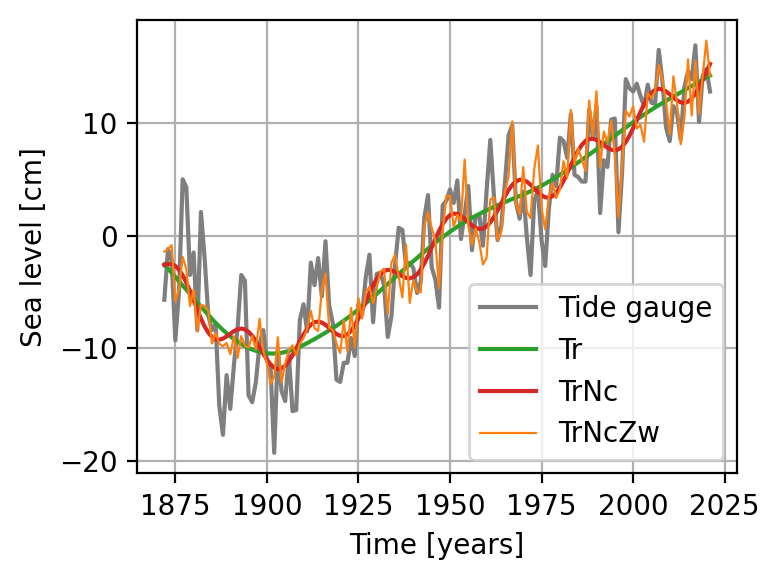

In [467]:
fig, ax = plt.subplots(1, 1, figsize=(4,3)) #14,5

panels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:blue']

tg_df['Average'].plot(label='Tide gauge', color='tab:grey')
res_nr.total.plot(label=short_names[0], color=colors[0])
res_nt.total.plot(label=short_names[1], color=colors[1])
res_na.total.plot(label=short_names[2], color=colors[2], linewidth=0.8)

ax.set_ylabel('Sea level [cm]')
ax.grid(True)
ax.set_xlabel('Time [years]')
#ax.text(0.01, 0.92, panels[idx], transform=ax.flat[idx].transAxes, size=14)

ax.legend(loc='lower right')

    
fig.tight_layout()

plt.savefig(f'./figures/{region}/{bootsize}/TideGauge_StatModels.pdf', dpi=150)

### Wind contribution to sea level

In [468]:
wind_rec = pd.read_csv(f'{output_dir}{bootsize}/WindInfluence.csv')
wind_rec.set_index('time', inplace=True)

In [469]:
# Estimate the linear trend for different periods

mid_point = int(len(wind_rec.index)/2)

lin_trend_na1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['NearestPointAverage_trend'].iloc[0:mid_point]).slope*10, 2)
lin_trend_na2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['NearestPointAverage_trend'].iloc[mid_point:-1]).slope*10, 2)

lin_trend_pd1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['PressureDifference_trend'].iloc[0:mid_point]).slope*10, 2)
lin_trend_pd2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['PressureDifference_trend'].iloc[mid_point:-1]).slope*10, 2)


In [470]:
lin_trend_na1, lin_trend_na2, lin_trend_pd1, lin_trend_pd2

(0.15, 0.12, 0.42, 0.14)

In [471]:
# Standard error in the estimation of the linear trend

lin_trend_se_na1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['NearestPointAverage_trend'].iloc[0:mid_point]).stderr*10, 3)
lin_trend_se_na2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['NearestPointAverage_trend'].iloc[mid_point:-1]).stderr*10, 3)

lin_trend_se_pd1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['PressureDifference_trend'].iloc[0:mid_point]).stderr*10, 3)
lin_trend_se_pd2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['PressureDifference_trend'].iloc[mid_point:-1]).stderr*10, 3)

In [472]:
lin_trend_se_na1, lin_trend_se_na2, lin_trend_se_pd1, lin_trend_se_pd2

(0.0, 0.001, 0.01, 0.003)

These standard errors are very small. The uncertainty in estimating the trend in wind influence on sea level does not come from fitting a linear trend to a wind time series (which these standard errors measure), it comes from the wind data and the method itself. 

Therefore the uncertainty is better estimated by looking at the difference between two methods which is what we do in the paper.

/var/folders/sg/bjgd139d48v526p07tp867mh0000gn/T/ipykernel_13859/2417332222.py:33: RuntimeWarning: divide by zero encountered in divide
  xf_p = 1/xf_mtm


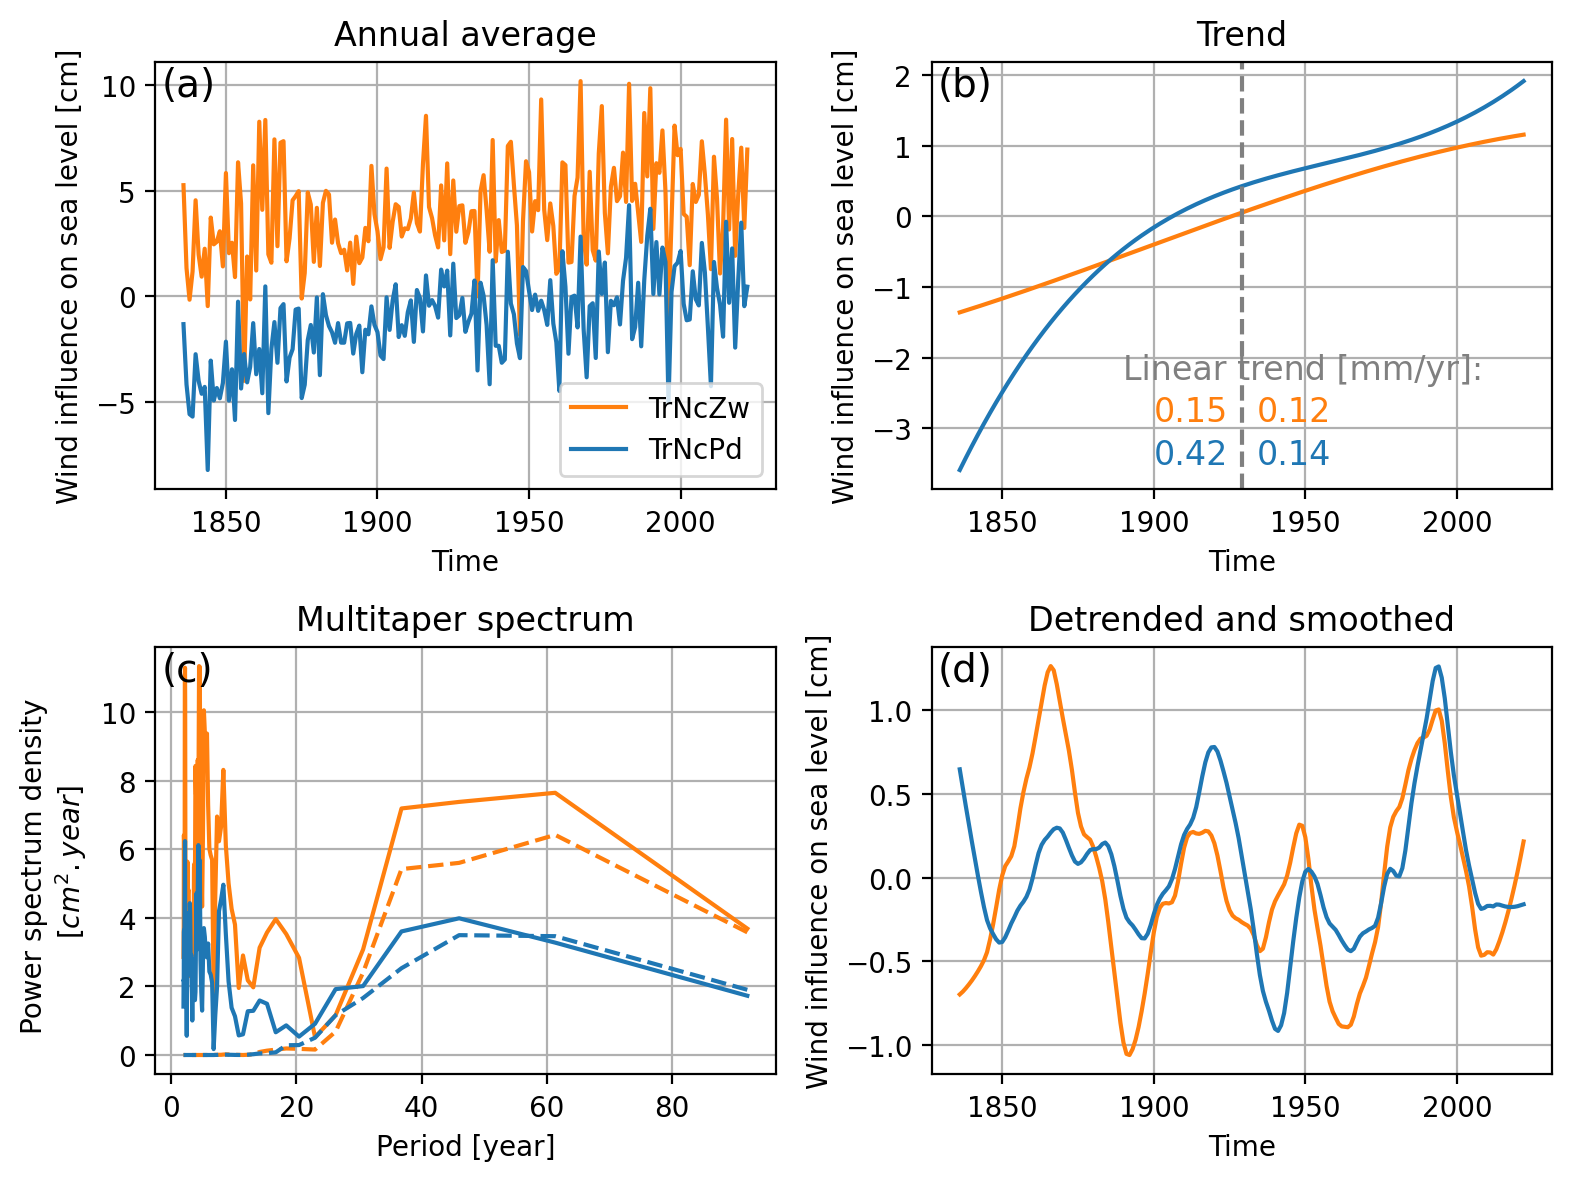

In [473]:
fig, ax = plt.subplots(2, 2, figsize=(8,6)) #14, 10

# Panel 1
wind_rec[['NearestPointAverage', 'PressureDifference']].plot(ax=ax[0,0], color=[colors[2], colors[3]])

ax[0,0].legend(['TrNcZw', 'TrNcPd'])
ax[0,0].set_title('Annual average')
ax[0,0].set_ylabel('Wind influence on sea level [cm]')
ax[0,0].set_xlabel('Time')

# Panel 2
(wind_rec['NearestPointAverage_trend']-wind_rec['NearestPointAverage_trend'].mean() ).plot(ax=ax[0,1], color=colors[2])
(wind_rec['PressureDifference_trend']-wind_rec['PressureDifference_trend'].mean() ).plot(ax=ax[0,1], color=colors[3])                                                                                                          

ax[0,1].text(1900, -2.9, lin_trend_na1, size=12, color=colors[2])
ax[0,1].text(1934, -2.9, lin_trend_na2, size=12, color=colors[2])

ax[0,1].text(1900, -3.5, lin_trend_pd1, size=12, color=colors[3])
ax[0,1].text(1934, -3.5, lin_trend_pd2, size=12, color=colors[3])

ax[0,1].text(1890, -2.3, 'Linear trend [mm/yr]:', size=12, color='grey')

ax[0,1].axvline(x=wind_rec.index[mid_point], color='grey', linestyle='--')

ax[0,1].set_title('Trend')
ax[0,1].set_ylabel('Wind influence on sea level [cm]')
ax[0,1].set_xlabel('Time')

# Panel 3
xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['NearestPointAverage_dt'].values, 1)

# Change x-axis from freqency to period
xf_p = 1/xf_mtm
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='NPA', color=colors[2])

xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['NearestPointAverage_lowess'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='NPA', color=colors[2], linestyle = 'dashed')

xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['PressureDifference_dt'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='PD', color=colors[3])

xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['PressureDifference_lowess'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='PD', color=colors[3], linestyle = 'dashed')

ax[1,0].set_title('Multitaper spectrum')
ax[1,0].set_ylabel('Power spectrum density \n'+r'$[cm^2.year]$')
ax[1,0].set_xlabel('Period [year]')

# Panel 4
wind_rec[['NearestPointAverage_lowess', 'PressureDifference_lowess']].plot(ax=ax[1,1], color=[colors[2], colors[3]])

ax[1,1].set_title('Detrended and smoothed')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('Wind influence on sea level [cm]')

ax[1,1].get_legend().remove()

for idx in range(4):
    ax.flat[idx].text(0.01, 0.92, panels[idx], 
                      transform=ax.flat[idx].transAxes, size=14)
    ax.flat[idx].grid(True)

fig.tight_layout()

plt.savefig(f'./figures/{region}/{bootsize}/WindInfluenceComp_lowess21.pdf', dpi=150)

### Rate of sea level rise

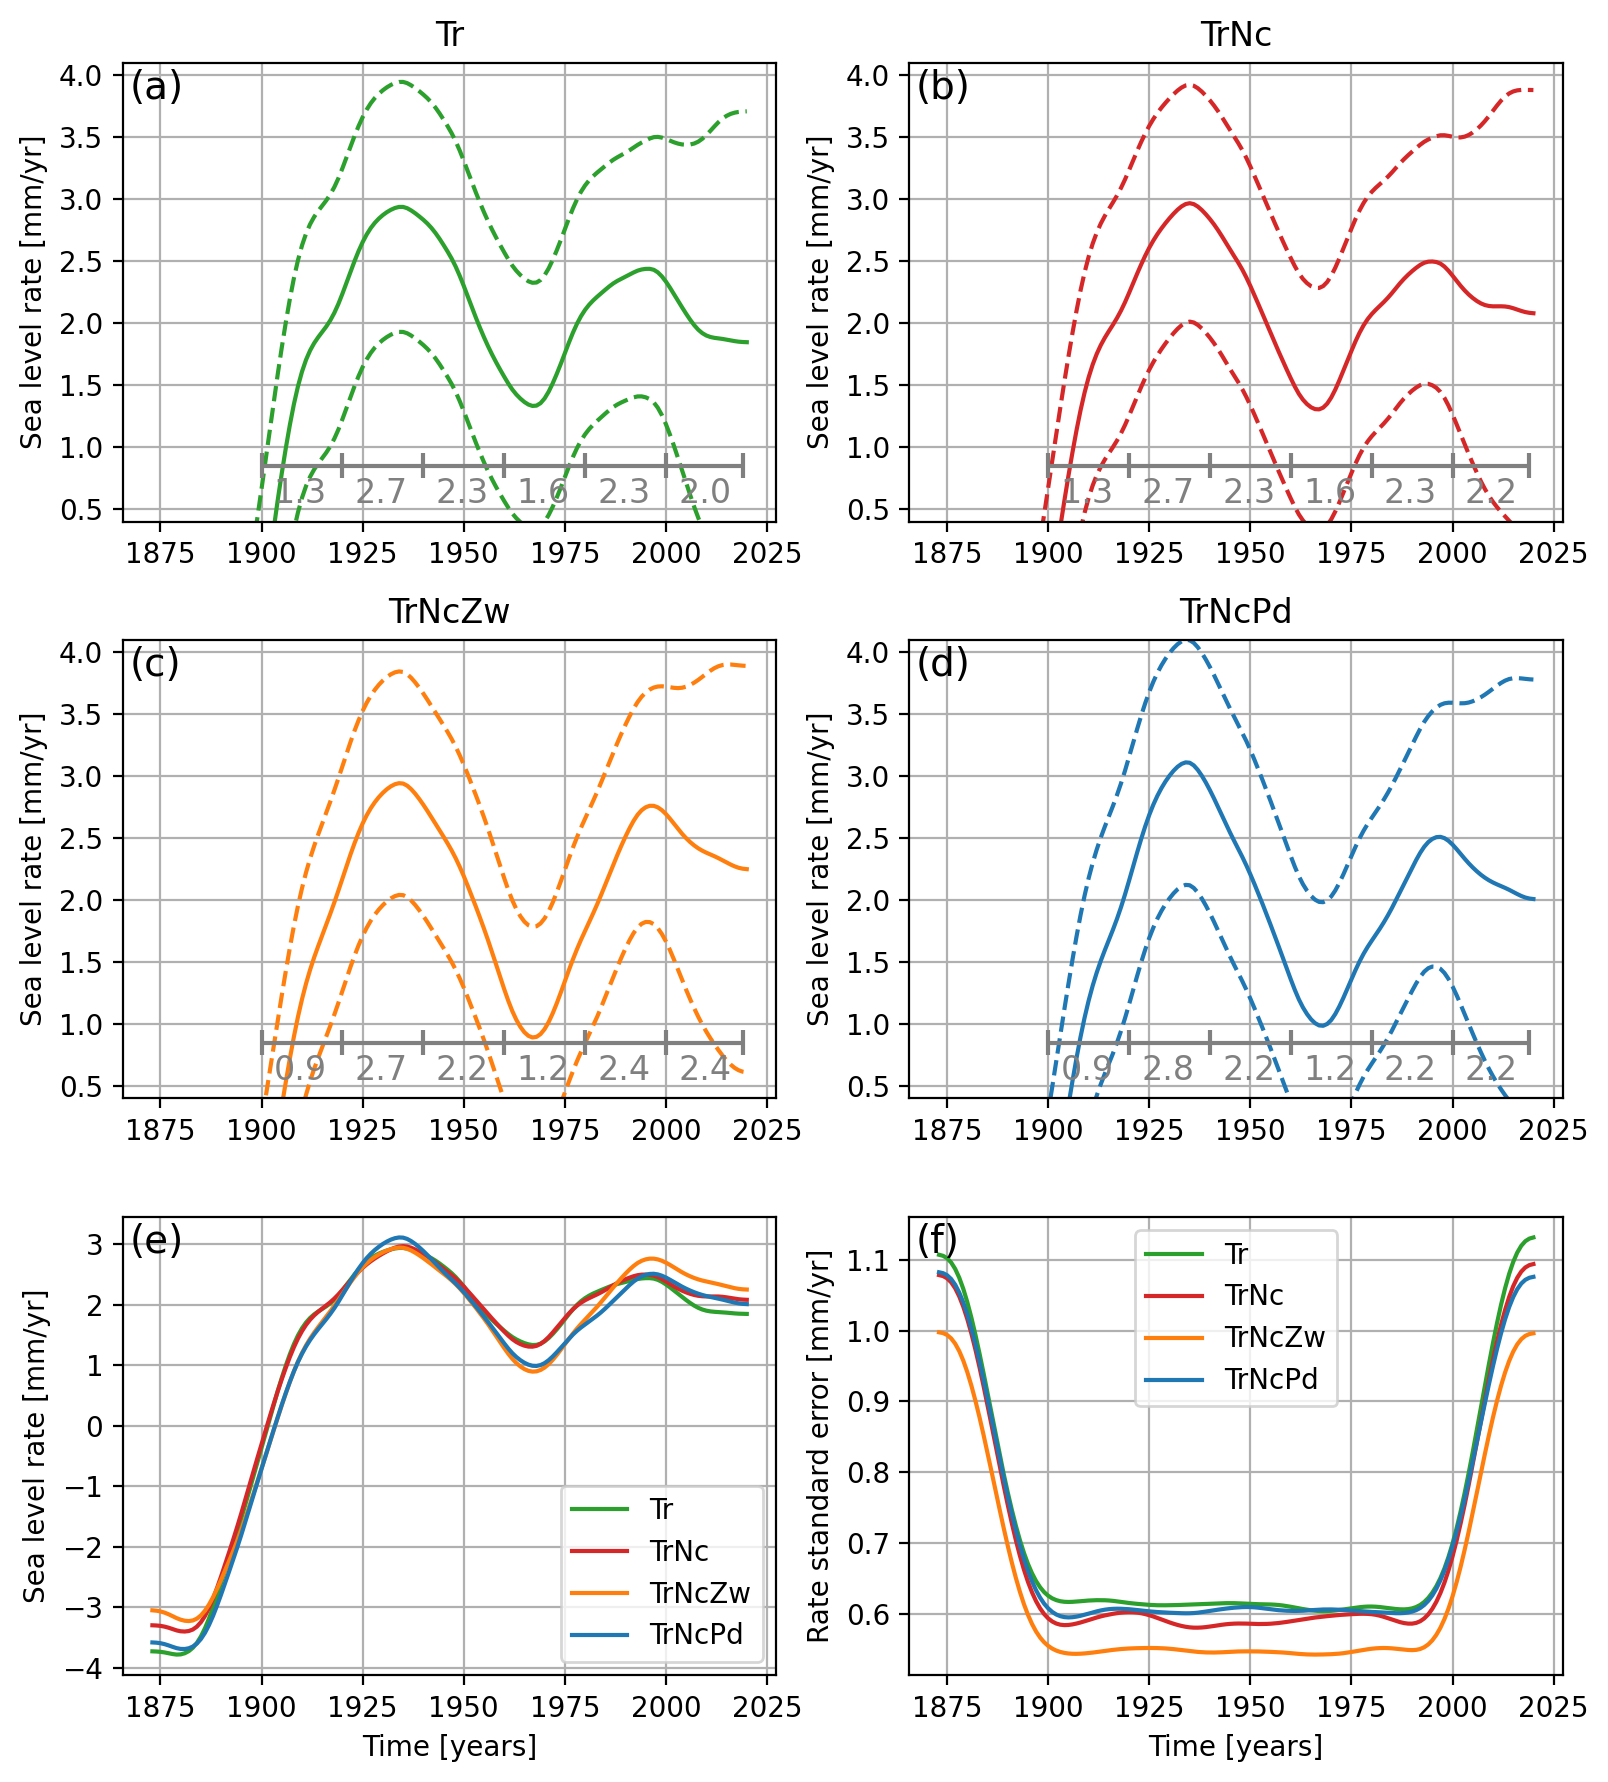

In [474]:
list_st = [1900, 1920, 1940, 1960, 1980, 2000]

fig, ax = plt.subplots(3, 2, figsize=(8,9))

for idx, res in enumerate([rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd]):
    
    res['0.5'].plot(ax=ax.flat[idx], title=short_names[idx], color=colors[idx])
    res['0.05'].plot(ax=ax.flat[idx], linestyle='dashed', 
                                          color=colors[idx])
    res['0.95'].plot(ax=ax.flat[idx], linestyle='dashed', 
                                          color=colors[idx])
    
    ax.flat[idx].set_xlabel('')
    ax.flat[idx].set_ylabel('Sea level rate [mm/yr]')
    ax.flat[idx].set_ylim([0.4, 4.1])
    ax.flat[idx].grid(True)
    ax.flat[idx].text(0.01, 0.92, panels[idx], transform=ax.flat[idx].transAxes, 
                      size=14)
    
    ax.flat[idx].hlines(y=0.85, xmin=list_st[0], xmax=list_st[5]+19, 
                        color='grey', linestyle='-')
    #ax.flat[idx].hlines(y=0.85, xmin=list_st[5], xmax=list_st[5]+19, 
    #                    color='grey', linestyle='-')
    
    for st in list_st:
        avg_rate = round(res.loc[st:st+19,'0.5'].mean(axis=0),1)
        ax.flat[idx].text(st+3, 0.55, avg_rate, size=12, color='grey')
        ax.flat[idx].vlines(x=st, ymin=0.75, ymax=0.95, color='grey', 
                            linestyle='-')
    ax.flat[idx].vlines(x=st+19, ymin=0.75, ymax=0.95, color='grey', linestyle='-')

rates_q_nr['0.5'].plot(ax=ax.flat[4], color=colors[0], label=short_names[0])
rates_q_nt['0.5'].plot(ax=ax.flat[4], color=colors[1], label=short_names[1])
rates_q_na['0.5'].plot(ax=ax.flat[4], color=colors[2], label=short_names[2])
rates_q_pd['0.5'].plot(ax=ax.flat[4], color=colors[3], label=short_names[3])

ax.flat[4].set_ylabel('Sea level rate [mm/yr]')
ax.flat[4].set_xlabel('Time [years]')
ax.flat[4].legend()
ax.flat[4].grid(True)
ax.flat[4].text(0.01, 0.92, panels[4], transform=ax.flat[4].transAxes, size=14)

ser_nr.plot(ax=ax.flat[5], color=colors[0], label=short_names[0])
ser_nt.plot(ax=ax.flat[5], color=colors[1], label=short_names[1])
ser_na.plot(ax=ax.flat[5], color=colors[2], label=short_names[2])
ser_pd.plot(ax=ax.flat[5], color=colors[3], label=short_names[3])

ax.flat[5].set_ylabel('Rate standard error [mm/yr]')
ax.flat[5].set_xlabel('Time [years]')
ax.flat[5].legend()
ax.flat[5].grid(True)
ax.flat[5].text(0.01, 0.92, panels[5], transform=ax.flat[5].transAxes, size=14)
    
fig.tight_layout()
plt.savefig(f'./figures/{region}/{bootsize}/RateSeaLevelTrend.pdf', dpi=150)

### Print the rate numbers and uncertainty range

In [475]:
print('Format: Median [0.05, 0.95]')

list_st = [1900, 1920, 1940, 1960, 1980, 2000, 1890, 1960, 1890]
list_pr = [19, 19, 19, 19, 19, 19, 69, 61, 131]

for idx, res in enumerate([rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd]):
    print('')
    print(f'Model: {short_names[idx]}')
    
    trend_lst = []
    if idx == 0:
        period_lst = []
          
    for idx2, st in enumerate(list_st):
        avg_rate = round(res.loc[st:st+list_pr[idx2],'0.5'].mean(axis=0),1)
        low_bound = round(res.loc[st:st+list_pr[idx2],'0.05'].mean(axis=0),1)
        high_bound = round(res.loc[st:st+list_pr[idx2],'0.95'].mean(axis=0),1)
        
        print(f'Period: {st}-{st+list_pr[idx2]}')
        print(f'{avg_rate} [{low_bound},{high_bound}]')
        
        if idx == 0:
            period_lst.append(f'{st}-{st+list_pr[idx2]}')
        
        trend_lst.append(f'{avg_rate} [{low_bound},{high_bound}]')
        
    if idx == 0:
        df = pd.DataFrame({'Period': period_lst}).set_index('Period')
        
    df[short_names[idx]] = trend_lst
        
table_rates = df.T

Format: Median [0.05, 0.95]

Model: Tr
Period: 1900-1919
1.3 [0.2,2.3]
Period: 1920-1939
2.7 [1.7,3.8]
Period: 1940-1959
2.3 [1.3,3.3]
Period: 1960-1979
1.6 [0.6,2.6]
Period: 1980-1999
2.3 [1.3,3.4]
Period: 2000-2019
2.0 [0.4,3.5]
Period: 1890-1959
1.6 [0.5,2.6]
Period: 1960-2021
2.0 [0.8,3.2]
Period: 1890-2021
1.8 [0.6,2.9]

Model: TrNc
Period: 1900-1919
1.3 [0.3,2.2]
Period: 1920-1939
2.7 [1.8,3.7]
Period: 1940-1959
2.3 [1.3,3.3]
Period: 1960-1979
1.6 [0.6,2.5]
Period: 1980-1999
2.3 [1.4,3.3]
Period: 2000-2019
2.2 [0.7,3.7]
Period: 1890-1959
1.6 [0.6,2.6]
Period: 1960-2021
2.0 [0.9,3.2]
Period: 1890-2021
1.8 [0.7,2.9]

Model: TrNcZw
Period: 1900-1919
0.9 [0.0,1.8]
Period: 1920-1939
2.7 [1.8,3.6]
Period: 1940-1959
2.2 [1.3,3.1]
Period: 1960-1979
1.2 [0.3,2.1]
Period: 1980-1999
2.4 [1.5,3.3]
Period: 2000-2019
2.4 [1.0,3.8]
Period: 1890-1959
1.4 [0.5,2.3]
Period: 1960-2021
2.0 [0.9,3.1]
Period: 1890-2021
1.7 [0.7,2.7]

Model: TrNcPd
Period: 1900-1919
0.9 [-0.1,1.9]
Period: 1920-1939
2.8

In [476]:
table_rates

Period,1900-1919,1920-1939,1940-1959,1960-1979,1980-1999,2000-2019,1890-1959,1960-2021,1890-2021
Tr,"1.3 [0.2,2.3]","2.7 [1.7,3.8]","2.3 [1.3,3.3]","1.6 [0.6,2.6]","2.3 [1.3,3.4]","2.0 [0.4,3.5]","1.6 [0.5,2.6]","2.0 [0.8,3.2]","1.8 [0.6,2.9]"
TrNc,"1.3 [0.3,2.2]","2.7 [1.8,3.7]","2.3 [1.3,3.3]","1.6 [0.6,2.5]","2.3 [1.4,3.3]","2.2 [0.7,3.7]","1.6 [0.6,2.6]","2.0 [0.9,3.2]","1.8 [0.7,2.9]"
TrNcZw,"0.9 [0.0,1.8]","2.7 [1.8,3.6]","2.2 [1.3,3.1]","1.2 [0.3,2.1]","2.4 [1.5,3.3]","2.4 [1.0,3.8]","1.4 [0.5,2.3]","2.0 [0.9,3.1]","1.7 [0.7,2.7]"
TrNcPd,"0.9 [-0.1,1.9]","2.8 [1.8,3.8]","2.2 [1.2,3.2]","1.2 [0.2,2.2]","2.2 [1.2,3.2]","2.2 [0.7,3.7]","1.4 [0.4,2.4]","1.9 [0.7,3.0]","1.6 [0.5,2.7]"


## Make table containing all different trends mentioned in the paper

For the 4 GAMs: Tr, TrNc, TrNcZw, TrNcPd

For the sea-level trend: 1900-1919, 1920-1939, 1940-1959, 1960-1979, 1980-1999, 2000-2019, 1890-2019, 1890-1960s 1960s-2019

For the wind-driven sea-level: whole period, two half periods. Where to add this?

In [477]:
print(table_rates.to_latex())

\begin{tabular}{llllllllll}
\toprule
Period &       1900-1919 &      1920-1939 &      1940-1959 &      1960-1979 &      1980-1999 &      2000-2019 &      1890-1959 &      1960-2021 &      1890-2021 \\
\midrule
Tr     &   1.3 [0.2,2.3] &  2.7 [1.7,3.8] &  2.3 [1.3,3.3] &  1.6 [0.6,2.6] &  2.3 [1.3,3.4] &  2.0 [0.4,3.5] &  1.6 [0.5,2.6] &  2.0 [0.8,3.2] &  1.8 [0.6,2.9] \\
TrNc   &   1.3 [0.3,2.2] &  2.7 [1.8,3.7] &  2.3 [1.3,3.3] &  1.6 [0.6,2.5] &  2.3 [1.4,3.3] &  2.2 [0.7,3.7] &  1.6 [0.6,2.6] &  2.0 [0.9,3.2] &  1.8 [0.7,2.9] \\
TrNcZw &   0.9 [0.0,1.8] &  2.7 [1.8,3.6] &  2.2 [1.3,3.1] &  1.2 [0.3,2.1] &  2.4 [1.5,3.3] &  2.4 [1.0,3.8] &  1.4 [0.5,2.3] &  2.0 [0.9,3.1] &  1.7 [0.7,2.7] \\
TrNcPd &  0.9 [-0.1,1.9] &  2.8 [1.8,3.8] &  2.2 [1.2,3.2] &  1.2 [0.2,2.2] &  2.2 [1.2,3.2] &  2.2 [0.7,3.7] &  1.4 [0.4,2.4] &  1.9 [0.7,3.0] &  1.6 [0.5,2.7] \\
\bottomrule
\end{tabular}



/var/folders/sg/bjgd139d48v526p07tp867mh0000gn/T/ipykernel_13859/1721568710.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_rates.to_latex())
